# Automatic speech transcription using Whisper

This tutorial guides you through using **Whisper** (OpenAI's ASR) improved by **WhisperX** for fast and timestamped speech transcription. 

Whisper is a powerful automatic speech recognition (ASR) model that can transcribe audio in multiple languages (e.g., English, Italian, Dutch, Japanese, Chinese, Spanish, etc.). Whisper provides 5 multilingual model sizes as follows:

|  Size  | Parameters | English-only model | Multilingual model | Required VRAM | Relative speed |
|:------:|:----------:|:------------------:|:------------------:|:-------------:|:--------------:|
|  tiny  |    39 M    |     `tiny.en`      |       `tiny`       |     ~1 GB     |      ~32x      |
|  base  |    74 M    |     `base.en`      |       `base`       |     ~1 GB     |      ~16x      |
| small  |   244 M    |     `small.en`     |      `small`       |     ~2 GB     |      ~6x       |
| medium |   769 M    |    `medium.en`     |      `medium`      |     ~5 GB     |      ~2x       |
| large  |   1550 M   |        N/A         | `large/large-v2/large-v3` |    ~10 GB     |       1x       |

> **Tip:** Smaller models run faster but yield lower accuracy. Choose based on your trade-off needs.

**Aknowledgement**: this tutorial was adopted from the [WhisperX](https://github.com/m-bain/whisperX):the state-of-the-art automatic speech recognition pipeline based on OpenAI's [Whisper](https://github.com/openai/whisper). The materials and the approach were also adapted from a tutorial by [Sho Akamine](https://github.com/ShoAkamine/whisperx_tutorial). 


### ⚙️ Why Use WhisperX?

Whisper’s out‑of‑the‑box transcripts are robust, but:

* **No word‑level timestamps**
* **Imprecise silence handling**

**WhisperX** fixes this by:

1. **Forced alignment** for accurate word (and character) timestamps
2. **Optimized backend** (via faster-whisper)
3. **Customizable ASR options** tailored to linguistic experiments



### 📝 Notebook Overview

1. **Setup**

   * Install packages, set paths
2. **Model Loading**

   * Choose model size, device, ASR parameters
3. **Preprocessing**

   * Convert videos → WAV
4. **Transcription + Alignment**

   * Run Whisper, then WhisperX aligner
   * Save JSON with segments + timestamps
5. **Export**

   * TSV (ELAN), TextGrid (Praat), plain-text (WebMAUS), SRT (Captions)

In [2]:
import whisperx
import pandas as pd
import os
import torch
import json
from tqdm import tqdm
import soundfile as sf

### import custom-made functions
from utils.video_converter import extract_wav
from utils.tsv_export import export_transcript_as_tsv, export_transcript_as_textonly
from utils.textgrid_export import export_transcript_as_textgrid
from utils.srt_export import export_transcript_as_srt


### 📂 Setup Folders

Before running the transcription pipeline, define and create the necessary directories:

- **Input folder** (`input_folder`): holds your `.wav` or `.mp4` files to transcribe  
- **Output folder** (`output_folder`): base path for all generated files  
- **JSON folder** (`json_folder`): stores WhisperX alignment results in JSON format  
- **TSV folder** (`tsv_folder`): for tab-delimited transcript exports  
- **SRT folder** (`srt_folder`): for subtitle (`.srt`) outputs  
- **TextGrid folder** (`textgrid_folder`): for Praat annotation files  

Each subfolder is created automatically if it doesn’t exist (using `os.makedirs()`), ensuring the pipeline can write outputs without errors.


In [3]:

### define paths
input_folder = "./input_demo/" # this folder contains wav or mp4 files to be transcribed
output_folder = input_folder #+ "output/" # whisper output txt files and TextGrid files will be saved here in the "tsv" and "textgrid" folders, respectively
json_folder = input_folder + "json/"
# if folder does not exist, create it
if not os.path.exists(json_folder):
    os.makedirs(json_folder)
tsv_folder = input_folder + "tsv/"
if not os.path.exists(tsv_folder):
    os.makedirs(tsv_folder)
srt_folder = input_folder + "srt/"
if not os.path.exists(srt_folder):
    os.makedirs(srt_folder)
textgrid_folder = input_folder + "textgrid/"
if not os.path.exists(textgrid_folder):
    os.makedirs(textgrid_folder)
text_only_folder = input_folder + "text_only/"
if not os.path.exists(text_only_folder):
    os.makedirs(text_only_folder)


### 🧩 ASR Parameters Before Running the Pipleine

Customize `asr_options` for:

* **Beam size** (`beam_size`): quality vs. speed
* **No speech threshold** (`no_speech_threshold`): controls silence filtering
* **Word timestamps** (`word_timestamps`): `True` for word-level alignment
* **Temperature schedule**: boosts robustness in noisy data

In [4]:
model_size = "base" # change to "large-v3" for better performance (note that it is significantly slower)
language = None # specify the language if needed (e.g., "en" for English, "ja" for Japanese, etc.); None for auto-detection
prompt = "" # specify the prompt if needed. For single word production experiements, you may provide the list of words in the prompt for better performance
#===========================================================


### Load the whisper model
# set the device, batch size, and compute type
device = 'cuda' if torch.cuda.is_available() else 'cpu' # setting device on GPU if available, else CPU
batch_size = 16 # reduce the batch_size if low on GPU memory
compute_type = "float16" if device == "cuda" else "default"

print(f"* Using device: {device} \n* Batch size: {batch_size} \n* Model size: {model_size} \n* Compute type: {compute_type}")
    

* Using device: cpu 
* Batch size: 16 
* Model size: base 
* Compute type: default


### 🚀 Running the Pipeline

In [5]:
# load model from whisper
model = whisperx.load_model(model_size, device, 
                            compute_type=compute_type,
                            language=language)


### convert the video files to wav files if they don't exist
# iterate over files in the videos folder & apply whisper model on each videos
for filename in os.listdir(input_folder):
    path = os.path.join(input_folder, filename)
    extract_wav(path)

### Transcribe all audio/video files in the input folder
# iterate over files in the videos folder & apply whisper model on each videos
existed_count = 0
input_files = [f for f in os.listdir(input_folder) if f.endswith(".wav")]
for filename in tqdm(input_files):
    path = os.path.join(input_folder, filename)

    # run the whisper model on the wav files (not the video files)
    if filename.endswith(".wav"):
        # check if the output file already exists
        output_filename = filename.split(".")[0] + ".txt"
        if os.path.exists(os.path.join(output_folder, "tsv", output_filename)):
            existed_count += 1
        else:
            ### 1. Transcribe with original whisper (batched)
            audio = whisperx.load_audio(path)
            result = model.transcribe(audio, batch_size=batch_size)

            ### 2. Align whisper output
            model_a, metadata = whisperx.load_align_model(language_code=result["language"], device=device)
            result_aligned = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=True)

            ### 3. save the aligned result to a json file
            json_save_path = os.path.join(output_folder, "json", output_filename.split(".")[0] + ".json")
            with open(json_save_path, "w") as f:
                json.dump(result_aligned, f, indent=4, ensure_ascii=False) 

if existed_count == 0:
    print("All files were processed successfully.")
else:
    print(f"{existed_count} files already existed in the output folder. They were skipped.")    


[2025-06-19 12:30:58.036] [ctranslate2] [thread 20557561] [warning] The compute type inferred from the saved model is float16, but the target device or backend do not support efficient float16 computation. The model weights have been automatically converted to use the float32 compute type instead.
Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../opt/anaconda3/envs/test2/lib/python3.10/site-packages/whisperx/assets/pytorch_model.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.7.1. Bad things might happen unless you revert torch to 1.x.


100%|██████████| 1/1 [00:00<00:00, 12483.05it/s]

1 files already existed in the output folder. They were skipped.


### 💾 Export Formats

```python
for j in os.listdir(OUTPUT_DIR):
    if j.endswith('.json'):
        data = json.load(open(f'{OUTPUT_DIR}/{j}'))
        basename = j.replace('.json','')
        export_transcript_as_tsv(data, f'{basename}.tsv', OUTPUT_DIR)
        export_transcript_as_textgrid(data, f'{basename}.TextGrid', OUTPUT_DIR)
        export_transcript_as_textonly(data, f'{basename}_plain.txt', OUTPUT_DIR)
        export_transcript_as_srt(f'{basename}.tsv', OUTPUT_DIR)
```

In [6]:
puncts = [".", "!", "?"] # list of punctuation marks where the segment should end

# load the aligned result from the json file
for json_filename in tqdm(os.listdir(json_folder)):
    if json_filename.endswith(".json"):
        json_file = os.path.join(json_folder, json_filename)
        with open(json_file, "r") as f:
            result_aligned = json.load(f)
            output_filename = json_filename.split(".json")[0] + ".txt"

        try:
            ### export the aligned result to various formats
            export_transcript_as_tsv(result_aligned, output_filename, output_folder, puncts)
            export_transcript_as_textgrid(result_aligned, output_filename, output_folder, puncts)
            export_transcript_as_textonly(result_aligned, output_filename, output_folder)
            export_transcript_as_srt(output_filename, tsv_folder, srt_folder)
        except Exception as e:
            print(f"Error in exporting {output_filename}: {e}")

100%|██████████| 1/1 [00:00<00:00, 54.85it/s]


In [ ]:
from 

In [ ]:
import os
from utils.time_format_converter import convert_time_float_to_string

def _float_to_ass_timestamp(t: float) -> str:
    """
    Convert a float timestamp (seconds) to ASS format H:MM:SS.CS
    where CS is centiseconds (two digits).
    """
    total_cs = int(round(t * 100))
    cs = total_cs % 100
    secs = (total_cs // 100) % 60
    mins = (total_cs // 6000) % 60
    hours = total_cs // 360000
    return f"{hours:d}:{mins:02d}:{secs:02d}.{cs:02d}"

def export_transcript_as_ass(result, filename, output_folder, puncts, play_res_x=1280, play_res_y=720):
    """
    Export aligned whisperx result to .ass (Advanced SubStation Alpha) subtitles.
    
    Args:
        result: the aligned JSON dict from whisperx
        filename: base name (with .txt or .json stripped)
        output_folder: path where "ass" subfolder will be created (if not exists)
        puncts: list of punctuation to consider segment boundaries
        play_res_x, play_res_y: video resolution metadata (optional)
    """
    # get formatted segments
    df, _ = format_transcript(result, filename, output_folder, puncts)
    
    ass_folder = os.path.join(output_folder, "ass")
    os.makedirs(ass_folder, exist_ok=True)
    ass_path = os.path.join(ass_folder, filename.replace(".txt", ".ass"))
    
    # minimal ASS header
    header = [
        "[Script Info]",
        "Title: WhisperX export",
        "ScriptType: v4.00+",
        f"PlayResX: {play_res_x}",
        f"PlayResY: {play_res_y}",
        "Timer: 100.0000",
        "",
        "[V4+ Styles]",
        "Format: Name, Fontname, Fontsize, PrimaryColour, SecondaryColour, OutlineColour, BackColour,"
        " Bold, Italic, Underline, StrikeOut, ScaleX, ScaleY, Spacing, Angle, BorderStyle, Outline, Shadow,"
        " Alignment, MarginL, MarginR, MarginV, Encoding",
        "Style: Default,Arial,20,&H00FFFFFF,&H0000FFFF,&H00000000,&H64000000,"
        "0,0,0,0,100,100,0,0,1,1,0,2,10,10,10,1",
        "",
        "[Events]",
        "Format: Layer, Start, End, Style, Name, MarginL, MarginR, MarginV, Effect, Text"
    ]
    
    with open(ass_path, "w", encoding="utf-8") as out:
        out.write("\n".join(header) + "\n")
        for _, row in df.iterrows():
            # parse start/end from your tsv format (strings like "00:01:23.45")
            # convert back to float to re-format into ASS centiseconds
            start_f = sum(float(x) * m for x, m in zip(row["start"].split(":"), [3600, 60, 1]))
            end_f   = sum(float(x) * m for x, m in zip(row["end"].split(":"),   [3600, 60, 1]))
            start_ass = _float_to_ass_timestamp(start_f)
            end_ass   = _float_to_ass_timestamp(end_f)
            text = row["text"].replace("\n", " ")  # no line-breaks in Dialogue
            line = f"Dialogue: 0,{start_ass},{end_ass},Default,,0,0,0,,{text}"
            out.write(line + "\n")
    
    print(f"Written ASS subtitles to {ass_path}")


---

### 📝 Exercise 1: Import Transcript to ELAN & Praat

Use the generated transcripts to annotate your media in **ELAN**. Let's use the elan file we generated with segmented gestures in the previous tutorial: **`salma_hayak_short_output.eaf`**

1. **Create a new ELAN project**  
    - File → New --> Select  **'salma_hayak_short_output.eaf'** from the second tutorial input folder
    - Select the source media (e.g., the `.mp4` in `input_folder`), click **»»**, then **OK**  
    - If you select the media with keypoints, you will not have the audio track, so you can select the audio file separately if needed.
        - Click on **Options** → **Linked file** to add the audio track if it is not already included.
        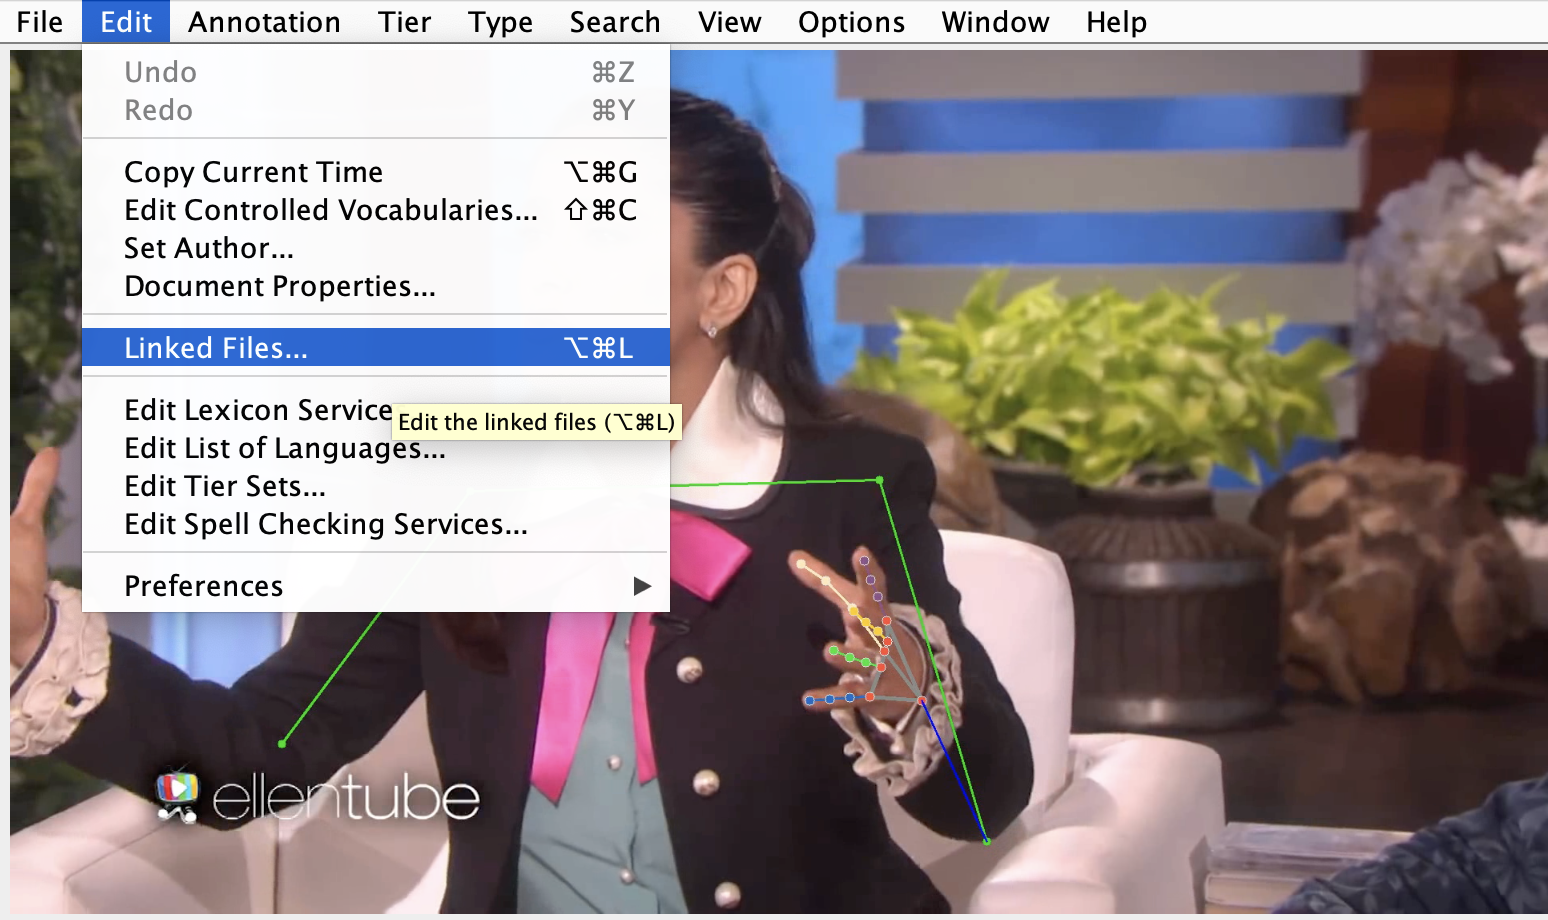
2. **Import the TSV transcript**  
    - File → Import → CSV/Tab-delimited Text file…  
    - Navigate to `tsv_folder`, select the `.tsv` file, click **OK**  
3. **Configure import options**  
    - **Delimiter**: Tab  
    - **First row of data**: 2  
    - **Column mapping**:  
      - `start` → Begin Time  
      - `end` → End Time  
      - `text` → Annotation  
4. Click **OK** to finish.

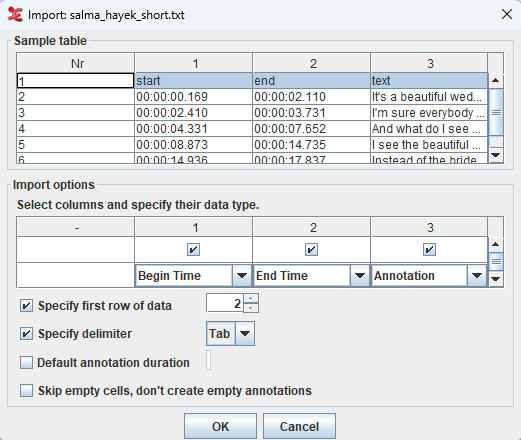


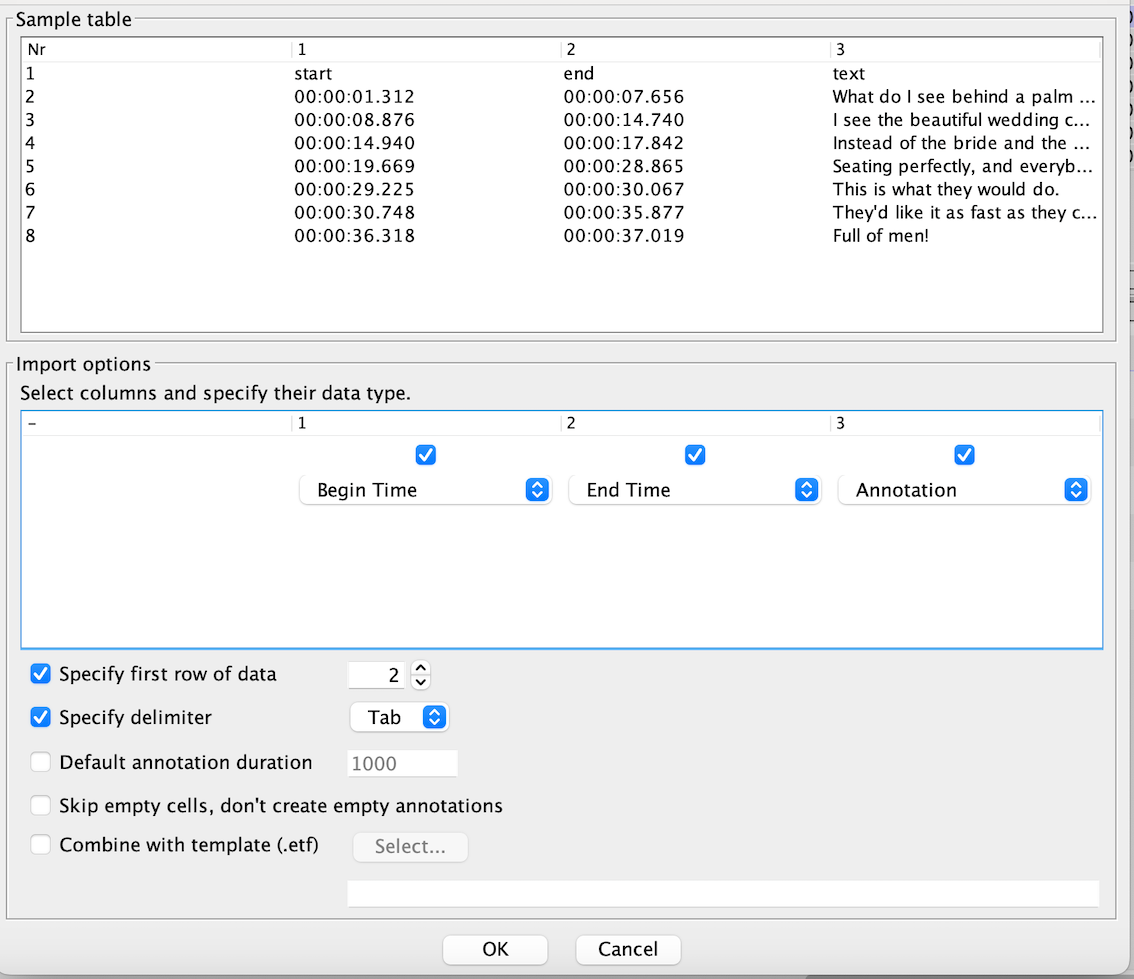

### <font color="orange">Exercise 2: Change the model size</font>
Change the model_size in the code above (code section 2, line 6) to "large-v3" and run the Whisper model again. After running the model, answer the following questions:
```markdown
### 🧪 Exercise 2: Change the Model Size

1. Update `model_size = "large-v3"` in Cell 4 and re-run the ASR pipeline.  
2. Time the transcription of a 37 s clip and save the TSV with a `_base` suffix:

```python
import time

# 1. Reload WhisperX with large-v3
model_size = "large-v3"
model = whisperx.load_model(
   model_size, device,
   compute_type=compute_type,
   language=language,
   asr_options=asr_options
)

# 2. Load audio & transcribe
audio = whisperx.load_audio(os.path.join(input_folder, 'your_clip.wav'))
start = time.time()
result = model.transcribe(audio, batch_size=batch_size)
elapsed = time.time() - start
print(f"large-v3 processing time: {elapsed:.2f}s")

# 3. Export TSV with "_base" suffix
basename = os.path.splitext('your_clip.wav')[0]
tsv_path = os.path.join(tsv_folder, f"{basename}_base.tsv")
export_transcript_as_tsv(result, tsv_path, puncts)
```

3. Answer the questions:
   - Is the transcript more accurate compared to the `base` model?
   - Did segment durations change? Which alignment is tighter?
   - How long did `large-v3` take for the 37 s video?
   - Did audience voices affect transcription accuracy?

> **Note:** Add `_base` to avoid name collisions in `tsv_folder`.